In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
# from scipy.sparse import coo_matrix
from pyspark.ml.recommendation import ALS

# import sklearn
# import random 

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, IndexToString
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator



In [2]:
from pyspark.sql import SparkSession


MAX_MEMORY = "5g"
spark = SparkSession.builder.appName("recommender")\
.config("spark.executor.memory", MAX_MEMORY)\
.config("spark.driver.memory", MAX_MEMORY)\
.getOrCreate()

# spark = SparkSession\
#         .builder\
#         .appName('recommender_system')\
#         .getOrCreate()

22/05/16 13:04:04 WARN Utils: Your hostname, RedStone-MacBookAir.local resolves to a loopback address: 127.0.0.1; using 172.30.1.38 instead (on interface en0)
22/05/16 13:04:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/16 13:04:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# 데이터 불러오기
customers = pd.read_csv("data/customers.csv")
tran = pd.read_csv("data/transactions_train.csv")
item = pd.read_csv("data/articles.csv")
rfm = pd.read_csv('data/df4.csv')

In [4]:
df = rfm.merge(tran, on=['customer_id', 'article_id'], how='left')

In [5]:
df.head()
df.count()

customer_id         45945696
article_id          45945696
rfm                 45945696
count               45945696
user_id             45945696
item_id             45945696
t_dat               45945696
price               45945696
sales_channel_id    45945696
dtype: int64

In [6]:
df = df.drop(['price','sales_channel_id', 'count'], axis=1)
df

,customer_id,article_id,rfm,user_id,item_id,t_dat
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001.0,5.472143,2,40179,2018-09-20
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001.0,5.472143,2,40179,2018-09-24
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023.0,3.484524,2,10520,2018-09-20
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004.0,1.993809,7,6387,2018-09-20
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003.0,1.993809,7,46304,2018-09-20
...,...,...,...,...,...,...
45945691,fff2282977442e327b45d8c89afde25617d00124d0f999...,891322004.0,10.000000,1371691,100629,2020-09-18
45945692,fff2282977442e327b45d8c89afde25617d00124d0f999...,891322004.0,10.000000,1371691,100629,2020-09-22
45945693,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,918325001.0,9.503095,1371721,104053,2020-09-22
45945694,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,833459002.0,5.527857,1371747,88521,2020-09-22


In [4]:
tran['t_dat'].min()

'2018-09-20'

In [5]:
tran['t_dat'].max()

'2020-09-22'

In [7]:
df_train = df[df['t_dat'] <= "2020-01ㅋ-01"]
df_test = df[df['t_dat'] >= "2020-01-02"]

In [16]:
df_train["t_dat"].count()

30563763

In [24]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15381933 entries, 15 to 45945695
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   customer_id  object 
 1   article_id   float64
 2   rfm          float64
 3   user_id      int64  
 4   item_id      int64  
 5   t_dat        object 
dtypes: float64(2), int64(2), object(2)
memory usage: 821.5+ MB


In [32]:
df_test.head()

,customer_id,article_id,rfm,user_id,item_id,t_dat
15,0008968c0d451dbc5a9968da03196fe20051965edde741...,529841001.0,8.000000,203,9116,2020-02-26
184,00ac5119d21281802ecd309e8c7fa0b598e0be861f21ca...,610776002.0,6.018572,3555,24837,2020-05-31
789,02e45757a6bc483ef7a9d086c3800bdab53ac1cb9840cf...,579541001.0,7.503095,15527,18586,2020-02-19
877,032bfa2ee5ed4729cb92b26f029bf391e24ffd9d820404...,658298001.0,10.000000,16939,38613,2020-07-09
2825,0c4bed26d668a494eb32f34c2a824a9dc21db3c1046351...,160442007.0,8.496905,65732,74,2020-04-19


In [9]:
df_train.to_csv('data/train.csv', index=False)

In [ ]:
# # coo 변환
# row = df['user_id'].values
# col = df['item_id'].values
# data = np.ones(tran.shape[0])
# coo_train = coo_matrix((data, (row, col)), shape=(len(ALL_USERS), len(ALL_ITEMS)))
# coo_train

In [5]:
df_spark = spark.read.csv("data/train.csv", inferSchema=True, header=True)
# coo_train = spark.createDataFrame(coo_train)

In [108]:
train, test = df_spark.randomSplit([0.75, 0.25])

rec = ALS(maxIter=10,
        regParam=0.01,
        userCol='user_id',
        itemCol='item_id',
        ratingCol='rfm', # label -> predict할 때는 필요 없음!
        nonnegative=True,
        # implicitPrefs = True,
        coldStartStrategy='drop')
# ALS모델 학습 -> dataframe을 넣어주기
rec_model = rec.fit(train)

# transform을 이용해 예측 -> dataframe을 넣어주기
pred_ratings = rec_model.transform(test)
pred_ratings.limit(5).toPandas()

,customer_id,article_id,rfm,user_id,item_id,t_dat,prediction
0,0001420326c217a367048472e05395373c40a039f6fd45...,566940004.0,1.496905,28,15400,2018-11-06,2.124766
1,0001420326c217a367048472e05395373c40a039f6fd45...,617249011.0,5.472143,28,26497,2018-11-10,5.463881
2,0001420326c217a367048472e05395373c40a039f6fd45...,617249011.0,5.472143,28,26497,2018-11-13,5.463881
3,0001420326c217a367048472e05395373c40a039f6fd45...,638114001.0,5.472143,28,33278,2018-11-10,5.463630
4,0001420326c217a367048472e05395373c40a039f6fd45...,638114001.0,5.472143,28,33278,2018-11-13,5.463630


In [7]:
u = rec_model.recommendForAllUsers(5)

/opt/homebrew/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [8]:
u = u.toPandas()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081557 entries, 0 to 1081556
Data columns (total 2 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   user_id          1081557 non-null  int32 
 1   recommendations  1081557 non-null  object
dtypes: int32(1), object(1)
memory usage: 12.4+ MB


In [11]:
u.to_csv('data/u.csv', index=False)

In [6]:
u = pd.read_csv('data/u.csv')

In [7]:
user = u["user_id"].unique()

In [8]:
u.index

RangeIndex(start=0, stop=1081557, step=1)

In [9]:
buyItem = pd.DataFrame(columns=['user_id','article_id'])
buyItem

,user_id,article_id


In [10]:
def buyUser():
  global buyItem
  for i in tqdm(u.index):
    for j in range(5):
      a=str(u['recommendations'][i][j]).split(',')
      a = a[0][15:]
      b=u['user_id'][i]
      buyItem.loc[i]=[b,a]
      # buyItem = buyItem.append({'user_id':b, 'article_id':a}, ignore_index=True)
      # print(a[0][15:])

buyUser()
buyItem

  5%|▌         | 58203/1081557 [01:00<17:47, 958.24it/s] 


KeyboardInterrupt: 

In [66]:
u['user_id']

0               28
1               31
2               34
3               53
4               65
            ...   
1081552    1371918
1081553    1371927
1081554    1371939
1081555    1371971
1081556    1371975
Name: user_id, Length: 1081557, dtype: int32

In [70]:
u.loc[u['user_id'] == 32].array()

AttributeError: 'DataFrame' object has no attribute 'array'

In [157]:
u["recommendations"][756396][0]

Row(article_id=813113002, rating=26.393983840942383)

In [96]:
u.head()

,user_id,recommendations
0,28,"[(734914001, 30.603647232055664), (760528001, ..."
1,31,"[(755716001, 18.209762573242188), (678342016, ..."
2,34,"[(825664001, 32.688316345214844), (810384001, ..."
3,53,"[(485551006, 25.546480178833008), (813113002, ..."
4,65,"[(836274001, 29.742891311645508), (813113002, ..."


In [97]:
u.replace(',','')

,user_id,recommendations
0,28,"[(734914001, 30.603647232055664), (760528001, ..."
1,31,"[(755716001, 18.209762573242188), (678342016, ..."
2,34,"[(825664001, 32.688316345214844), (810384001, ..."
3,53,"[(485551006, 25.546480178833008), (813113002, ..."
4,65,"[(836274001, 29.742891311645508), (813113002, ..."
...,...,...
1081552,1371918,"[(813113002, 22.74728775024414), (734914001, 1..."
1081553,1371927,"[(799658001, 20.039321899414062), (734914001, ..."
1081554,1371939,"[(810384001, 33.16739273071289), (836274001, 2..."
1081555,1371971,"[(485551006, 21.19314956665039), (813113002, 2..."


In [92]:
u_dict = u.to_dict('records')

In [94]:
u_dict[0]['recommendations'][1]

Row(article_id=760528001, rating=27.24862289428711)

In [72]:
u_dict['recommendations'].values()

TypeError: list indices must be integers or slices, not str

In [36]:
u['recommendations'].str.split(", ")


0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
           ..
1081552   NaN
1081553   NaN
1081554   NaN
1081555   NaN
1081556   NaN
Name: recommendations, Length: 1081557, dtype: float64

In [36]:
pred_ratings.limit(100).toPandas()

,customer_id,article_id,rfm,user_id,item_id,t_dat,prediction
0,0001420326c217a367048472e05395373c40a039f6fd45...,566941002.0,1.000000,28,15407,2018-11-10,1.615213
1,0001420326c217a367048472e05395373c40a039f6fd45...,615797001.0,1.000000,28,26066,2018-11-07,10.822620
2,0001420326c217a367048472e05395373c40a039f6fd45...,617249011.0,5.472143,28,26497,2018-11-10,5.432347
3,0001420326c217a367048472e05395373c40a039f6fd45...,617249011.0,5.472143,28,26497,2018-11-13,5.432347
4,0001420326c217a367048472e05395373c40a039f6fd45...,617249011.0,5.472143,28,26497,2018-11-13,5.432347
...,...,...,...,...,...,...,...
95,00067622de3151a7219b4ed9922def50b51601fbe41418...,811340001.0,6.993809,155,83127,2019-09-07,7.551244
96,00067622de3151a7219b4ed9922def50b51601fbe41418...,836009001.0,5.503095,155,89074,2019-09-15,5.203204
97,00067622de3151a7219b4ed9922def50b51601fbe41418...,624383004.0,5.503095,155,28929,2019-09-30,4.431499
98,00067622de3151a7219b4ed9922def50b51601fbe41418...,624383007.0,5.503095,155,28931,2019-09-30,5.691515


In [12]:
df18 = pred_ratings.toPandas()

In [28]:
df18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7601518 entries, 0 to 7601517
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   customer_id  object 
 1   article_id   float64
 2   rfm          float64
 3   user_id      int32  
 4   item_id      int32  
 5   t_dat        object 
 6   prediction   float32
dtypes: float32(1), float64(2), int32(2), object(2)
memory usage: 319.0+ MB


In [29]:
user = df18["user_id"].unique()

In [30]:
user

array([     28,      31,      34, ..., 1371836, 1371855, 1371918],
      dtype=int32)

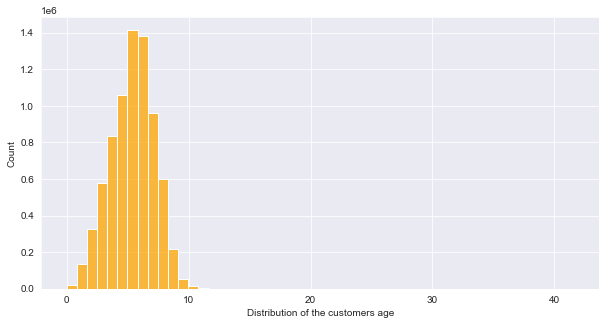

In [40]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=df18, x='prediction', bins=50, color='orange')
ax.set_xlabel('Distribution of the customers age')
plt.show()

In [109]:
# Get metric for training
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol='rfm',
                              predictionCol='prediction',
                              metricName='rmse')
# evaluate 메소드에 예측값 담겨있는 dataframe 넣어주기
rmse = evaluator.evaluate(pred_ratings)

mae_eval = RegressionEvaluator(labelCol='rfm',
                              predictionCol='prediction',
                              metricName='mae')
mae = mae_eval.evaluate(pred_ratings)

print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 0.9957165072756821
MAE: 0.6334563741915996


In [43]:
df18.head()

,customer_id,article_id,rfm,user_id,item_id,t_dat,prediction
0,0001420326c217a367048472e05395373c40a039f6fd45...,566941002.0,1.000000,28,15407,2018-11-10,1.615213
1,0001420326c217a367048472e05395373c40a039f6fd45...,615797001.0,1.000000,28,26066,2018-11-07,10.822620
2,0001420326c217a367048472e05395373c40a039f6fd45...,617249011.0,5.472143,28,26497,2018-11-10,5.432347
3,0001420326c217a367048472e05395373c40a039f6fd45...,617249011.0,5.472143,28,26497,2018-11-13,5.432347
4,0001420326c217a367048472e05395373c40a039f6fd45...,617249011.0,5.472143,28,26497,2018-11-13,5.432347


In [31]:
# Pyspark Library #
# SQL
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import mean, col, split, regexp_extract, when, lit
# ML
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, IndexToString
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.recommendation import ALS

In [56]:
pre1 = rfm
pre1.head(10)

,customer_id,article_id,rfm,count,user_id,item_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001.0,20,1,2,40179
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023.0,8,1,2,10520
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004.0,5,1,7,6387
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003.0,5,1,7,46304
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004.0,5,1,7,46305
5,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687001.0,5,1,7,46302
6,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221001.0,6,1,7,6386
7,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,688873012.0,8,1,198,47416
8,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,501323011.0,11,1,198,5944
9,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,598859003.0,11,1,198,22540


In [110]:
asdf = spark.read.csv('data/train.csv', inferSchema=True, header=True)
unique_movies = asdf.select("article_id").distinct()

In [111]:
def top_movies(user_id, n):
    """
    특정 user_id가 좋아할 만한 n개의 영화 추천해주는 함수
    """
    # unique_movies 데이터프레임을 'a'라는 데이터프레임으로 alias시키기
    a = unique_movies.alias('a')

    # 특정 user_id가 본 영화들만 담은 새로운 데이터프레임 생성
    watched_movies = df.filter(df['user_id'] == user_id)\
                            .select('article_id')

    # 특정 user_id가 본 영화들을 'b'라는 데이터프레임으로 alias시키기
    b = watched_movies.alias('b')

    # unique_movies를 기준으로 watched_movies를 조인시켜서 user_id가 보지 못한 영화들 파악 가능
    total_movies = a.join(b, a['article_id'] == b['article_id'],
                        how='left')

    # b 데이터프레임의 title_new값이 결측치를 갖고 있는 행의 a.title_new를 뽑아냄으로써 user_id가 아직 못본 영화들 추출
    # col('b.title_new') => b 데이터프레임의 title_new칼럼 의미(SQL처럼 가능!)
    remaining_movies = total_movies\
                    .where(col('b.article_id').isNull())\
                    .select('a.article_id').distinct()
    # remaining_movies 데이터프레임에 특정 user_id값을 동일하게 새로운 변수로 추가해주기
    remaining_movies = remaining_movies.withColumn('user_id',
                                                lit(int(user_id)))
    # 위에서 만든 ALS 모델을 사용하여 추천 평점 예측 후 n개 만큼 view -> 
    recommender = rec_model.transform(remaining_movies)\
                        .orderBy('prediction', ascending=False)\
                        .limit(n)

    # pre = recommender.toPandas()
    # pre1 = rfm.merge(pre, on=['user_id', 'article_id'], how='right')
    # pre1 = rfm.merge(pre)
    # return pre
    return recommender.show(n, truncate=False)

# userid가 1817번인 유저가 볼만한 영화 상위 5개 추천해주기
top_movies(31, 5)

# StringIndexer로 만든 것을 역으로 바꾸기 위해 IndexToString사용(영화제목을 숫자->한글제목)
    # movie_title = IndexToString(inputCol='article_new',
    #                         outputCol='article_id',
    #                         labels=model.labels) #여기서 model.labels는 StringIndexer에서 fit시켰을 때 생긴 레이블. 즉, 영화 제목들
    # # transform해서 영화제목을 숫자->한글로 변환! => dataframe으로 반환
    # final_recommendations = movie_title.transform(recommender)

NameError: name 'col' is not defined